In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/machinelearning')
work_dir = os.getcwd()

# Utilizando uma rede convolutiva pré-treinada

Uma rede pré-treinada é um modelo que foi previamente treinado em uma base de dados maior. Se o dataset original é grande e variado o suficiente para a rede capturar os padrões de dados essenciais, então ela poderá ser utilizada como ponto de partida para o treino de redes que irão trabalhar em conjuntos de dados específicos. 

A portabilidade dos modelos é uma característica exclusiva dos modelos de deep learning que não encontra paralelo nos modelos tradicionais de machine learning. Por exemplo, pode-se utilizar um modelo pré-treinado em reconhecimento de imagens de gatos e cães para o treinar um modelo de reconhecimento de móveis. 

Neste exemplo será utilizada uma grande rede neural convolutiva que treinada na base de dados ImageNet. A ImageNet contém 1.4 milhões de images classificadas em 1.000 categorias distintas. Uma vez que a ImageNet contém várias categorias de animais domésticos espera-se que ela seja um bom ponto de partida para o treino de nossa rede menor.

A arquitetura de rede que será utilizada chama-se VGG16 e foi desenvolvida por Karen Simonyan e Andrew Zisserman em 2014. Outras arquiteturas famosas são ResNet, Inception, Inception-ResNet, Xception, etc... 

As duas formas mais comuns de utilização de uma rede pré-treinada são: *feature extraction* e *fine-tuning*. 

## Feature extraction

A extração de características consiste no uso das representações aprendidas por uma rede para extrair características adicionais de novas amostras. Estas características são então processadas por um novo classificador, o qual é treinado a partir do zero.

Como pode ser visto nos tópicos anteriores, as redes neurais convolutivas utilizadas em classificação de imagens são formadas de duas partes: a primeira consiste numa série de camadas convolutivas e de pooling e a segunda em um conjunto de camadas densamente conectadas. 

A primeira parte é chamada de base convolutiva do modelo e a segunda de classificador. No caso das redes neurais convolutivas a extração de características consiste em utilizar a base convolutiva de uma rede já treinada, rodar novos dados através da mesma e treinar um novo classificador.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

O método descrito acima se justifica porque a base convolutiva irá aprender padrões gerais das imagens enquanto o classificador irá se concentrar na probabilidade da imagem pertencer a uma categoria específica. Além disso a representação criada pelo classificador não contém a informação de *onde* a imagem a ser reconhecida estará na imagem como um todo. 

O nível de generalização (e portanto de reutilização) das representações extraidas por níveis convolutivos específicos depende da profundidade da camada no modelo. Camadas iniciais extraem mapas de características (*feature maps*) locais e altamente genéricos (tais como bordas, cores e texturas). Camadas que estejam mais a frente extraem informações mais abstratas tais como "orelha de um gato" ou "olho de um cão". 

Sendo assim, quanto mais o seu conjunto de dados específico diferir do conjunto utilizado para treinar a base convolutiva do modelo inicial, menos camadas convolutivas da base do mesmo deverão ser utilizadas. 

No caso da ImageNet entre as várias categorias aprendidas pelo modelo estão várias de cães e gatos. No entanto para manter o exemplo o mais genérico possível utilizaremos apenas as camadas convolutivas do mesmo. 

A seguir vamos utilizar a base convolutiva do modelo VGG16, treinado na ImageNet para extrair características específicas das nossas imagens de cães e gatos e então treinar um classificador de gato vs. cão a partir destas características. 

O modelo VGG16 já vem pré-carregado na Keras e pode ser importado do módulo `keras.applications`. A lista dos modelos pré-treinados no dataset ImageNet disponíveis na Keras inclui: 

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Observe a seguir o processo de criação de um modelo baseado no VGG16:

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))





58892288/58889256 [==============================] - 5s 0us/step




Foram utilizados três parâmetros na construção do modelo:

* `weights`, para especificar a partir de qual ponto de treino os pesos deverão ser inicializados.

* `include_top`, o qual define se o classificador (composto das camadas densamente conectadas no final do modelo original) deverá ou não ser utilizado. No caso da ImageNet este classificador corresponderia às 1.000 classes da mesma. Como iremos utilizar nosso próprio classificador (com apenas duas classes, cão e gato) o mesmo não será incluido.

* `input_shape`, o formato dos tensores de imagem que serão passados para o modelo. Este argumento é opcional e caso não seja utilizado o modelo irá processar entradas de qualquer tamanho (à custa de mais tempo de processamento. 

O resumo do modelo é apresentado a seguir:

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

O mapa de características final terá formato `(4, 4, 512)`. A partir dele será conectado o classificador.

Existem duas estratégias que podem ser adotadas neste momento: 

* Rodar a base convolutiva sobre a nossa base de dados, salvar os tensores resultantes no disco em um array numpy e então utilizar estes arrays como entrada de um classificador independente.

Esta solução é executada rapidamente, pois precisamos apenas passar as imagens de treino pela base convolutiva, a qual é a parte mais complexa do modelo. No entanto esta técnica não permite o uso de data augmentation, pois os dados só serão vistos uma vez. 

* Extender o modelo inicial (`conv_base`) pelo acréscimo de camadas do tipo `Dense` no topo do mesmo e rodar o modelo desde o início nos dados de entrada. 

Esta técnica permite o uso de data augmentation cada imagem irá passar pela base convolutiva antes de chegar no classificador. No entanto pelo mesmo motivo ela é muito mais lenta que a anterior. 



Primeiro vamos analisar o código necessário para gravar a saida da `conv_base` a partir dos nossos dados e utilizar esta saida como entrada de um modelo de classificação com camadas do tipo `Dense`. 

Para tal vamos executar o `ImageDataGenerator` para criar arrays numpy a partir das imagens gravadas em disco. As features destas imagens serão obtidas a partir do método `predict` do modelo `conv_base`.

In [0]:
# ATENÇÃO: A EXECUÇÃO DESTA CÉLULA É DEMORADA POIS REQUER A LEITURA DE DADOS
#  EM DISCO DE UMA GRANDE QUANTIDADE DE ARQUIVOS. OS RESULTADOS JÁ ESTÃO DISPONÍVEIS
#  EM ARRAYS NUMPY NO DISCO E PODEM SER CARREGADOS NA CÉLULA A SEGUIR
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join(work_dir, 'dados_cats_and_dogs_small')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Uma vez que os generators produzem dados de forma contínua,
            # ele deve ser interrompido após cada imagem ter sido vista uma vez.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# EXECUTE ESTA CÉLULA APENAS PARA SALVAR EM DISCO 
# OS ARRAYS NUMPY GERADOS NA ETAPA ANTERIOR
import numpy as np
np.save('./modelos/train_features',train_features)
np.save('./modelos/train_labels',train_labels)
np.save('./modelos/validation_features',validation_features)
np.save('./modelos/validation_labels',validation_labels)
np.save('./modelos/test_features', test_features)
np.save('./modelos/test_labels', test_labels)

In [0]:
# EXECUTE ESTA CÉLULA CASO PREFIRA CARREGAR OS ARRAYS NUMPY
#  DIRETAMENTE DO DISCO
train_features = np.load('./modelos/train_features.npy')
train_labels = np.load('./modelos/train_labels.npy')
validation_features = np.load('./modelos/validation_features.npy')
validation_labels = np.load('./modelos/validation_labels.npy')
test_features = np.load('./modelos/test_features.npy')
test_labels = np.load('./modelos/test_labels.npy')

As features extraidas do conjunto de dados original estão atualmente no formato `(samples, 4, 4, 512)`. Uma vez que elas serão passadas para um classificador com camadas do tipo `Dense`, os dados devem ser "alisados" (`Flatten`) para o formato `(samples, 8192)` (pois 4 x 4 x 512 = 8.192).

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

A partir deste ponto, o classificador com camadas do tipo `Dense` pode ser definido e treinado nos dados e rótulos que temos no momento. Observe o uso da técnica de dropout para regularizar os dados).

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 801us/step - loss: 0.5897 - acc: 0.6705 - val_loss: 0.4416 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 1s 308us/step - loss: 0.4303 - acc: 0.8100 - val_loss: 0.3594 - val_acc: 0.8710
Epoch 3/30
2000/2000 [==============================] - 1s 296us/step - loss: 0.3563 - acc: 0.8435 - val_loss: 0.3228 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 304us/step - loss: 0.3128 - acc: 0.8660 - val_loss: 0.3109 - val_acc: 0.8730
Epoch 5/30
2000/2000 [==============================] - 1s 294us/step - loss: 0.2903 - acc: 0.8850 - val_loss: 0.2835 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 1s 312

Veja que o treino ocorre de forma rápida. A seguir são apresentados os resultados do erro e da precisão em forma gráfica.

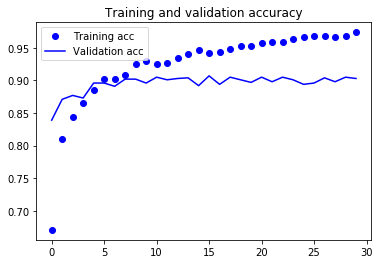

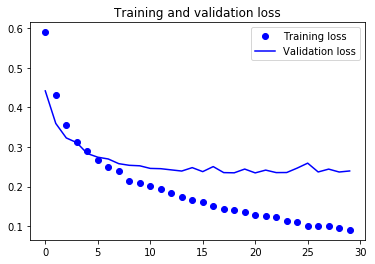

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Foi obtida uma precisão de 90% na validação, enquanto com o modelo treinado a partir do zero no exemplo anterior atingimos apenas 80%. 

No entanto os gráficos indicam um overfitting a partir da quarta época de treino, apesar do uso de uma camada com 50% de dropout. Isto ocorre porque esta técnica não permite o uso de data augmentation, recurso essencial para evitar o overfitting em pequenos grupos de imagens.



Vamos agora conhecer a segunda técnica: utilizar a base convolutiva do modelo pré-treinado e um novo classificador para criar um novo modelo e treinar o mesmo no nosso conjunto de dados. 

Uma vez que os modelos se comportam como camadas, iremos criar um novo modelo do tipo sequencial e utilizar como primeira camada o modelo `conv_base`. Em seguida incluiremos a camada de alisamento e duas camadas densas, uma com 256 neurons e função de ativação `relu` e a camada de saida com apenas um neuron e função de ativação `sigmoid` (vide a seguir):

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

O resumo do modelo então será:

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Observe que a base convolutiva VGG16 tem 14,714,688 de parâmetros e o classificador mais 2 milhões.

Antes de compilar e treinar o modelo devemos "congelar" a base convolutiva. Isto evitará que seus parâmetros sejam ajustados durante o treino. Caso contrário o erro proveniente dos pesos do classificador (que serão inicializados ao acaso) se propagarão para a base convolutiva, destruindo o aprendizado anterior do modelo.

O congelamento dos pesos na Keras é efetuado através da passagem do parâmetro `conv_base.trainable` para `False`

In [0]:
conv_base.trainable = True

In [0]:
print('Número de tensores passíveis de ajuste antes do congelamento do nível convolutivo:',
      len(model.trainable_weights))

Número de tensores passíveis de ajuste antes do congelamento do nível convolutivo: 30


In [0]:
conv_base.trainable = False

In [0]:
print('Número de tensores passíveis de ajuste antes do congelamento do nível convolutivo:',
      len(model.trainable_weights))

Número de tensores passíveis de ajuste antes do congelamento do nível convolutivo: 4


Os quatro tensores são os dois tensores de pesos das camadas do classificador e os dois tensores de bias. 

Após congelar os pesos o modelo deve ser recompilado antes de ser treinado para que a alteração seja efetivada. Caso contrário a mudança será ignorada durante o treino.

O modelo agora pode ser treinado com a mesma configuração de aumento de dados do tópico anterior:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Atenção: Os dados do grupo de validação não devem ser aumentados.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # diretório com as imagens de treino
        target_size=(150, 150), # todas as imagens são redimensionadas para 150x150 pixels
        batch_size=20,
        class_mode='binary') # Labels binários pois utilizaremos como erro a binary_crossentropy

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.5801 - acc: 0.7040 - val_loss: 0.4413 - val_acc: 0.8160
Epoch 2/30
 - 19s - loss: 0.4679 - acc: 0.7940 - val_loss: 0.3683 - val_acc: 0.8600
Epoch 3/30
 - 19s - loss: 0.4244 - acc: 0.8090 - val_loss: 0.3355 - val_acc: 0.8640
Epoch 4/30
 - 19s - loss: 0.3963 - acc: 0.8365 - val_loss: 0.3115 - val_acc: 0.8750
Epoch 5/30
 - 19s - loss: 0.3862 - acc: 0.8375 - val_loss: 0.2980 - val_acc: 0.8770
Epoch 6/30
 - 19s - loss: 0.3704 - acc: 0.8330 - val_loss: 0.2888 - val_acc: 0.8780
Epoch 7/30
 - 19s - loss: 0.3583 - acc: 0.8400 - val_loss: 0.2822 - val_acc: 0.8730
Epoch 8/30
 - 19s - loss: 0.3538 - acc: 0.8415 - val_loss: 0.2778 - val_acc: 0.8920
Epoch 9/30
 - 19s - loss: 0.3493 - acc: 0.8415 - val_loss: 0.2705 - val_acc: 0.8880
Epoch 10/30
 - 19s - loss: 0.3314 - acc: 0.8560 - val_loss: 0.2654 - val_acc: 0.8890
Epoch 11/30
 - 19s - loss: 0.3285 - acc: 0.8615 - val_loss: 0.2609 - val_ac

Como sempre salvamos o modelo após o treino em um arquivo do tipo .h5

In [0]:
model.save('./modelos/cats_and_dogs_small_3.h5')

E mais uma vez apresentamos os resultados do erro e da precisão de forma gráfica

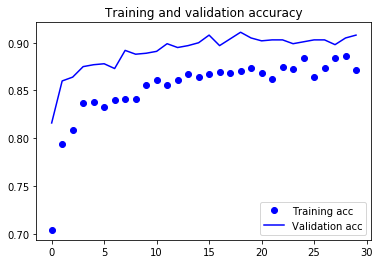

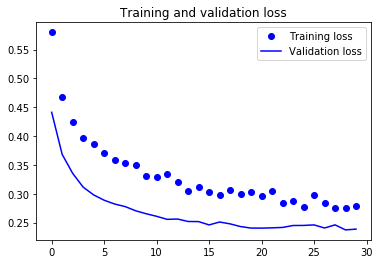

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Chegamos a uma precisão no conjunto de validação acima de 90%, bem melhor que no modelo menor, treinado a partir do zero. 

## Ajuste fino das camadas convolutivas

Esta técnica consiste em "descongelar" uma ou mais camadas da etapa final da base convolutiva e treinar a mesma junto com o classificador. 

A técnica tem este nome pois ela introduz um pequeno ajuste nas representações mais abstratas do modelo que está sendo reutilizado, de modo a torna-las mais relevantes para o problema atual.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

Observe que a camada que será descongelada deve ser treinada apenas com um classificador que já tiver passado pela etapa de treino. 

Mais uma vez, precisamos impedir que os pesos inicializados ao caso em um classificador não treinado se propaguem para a camada convolutiva descongelada e destruam o seu aprendizado anterior. 

As etapas envolvidas no processo de ajuste fino são as seguintes:

* 1) Criar o modelo, acrescentando o modelo Sequencial com camadas Densas denominado classificador na saida de uma base convolutiva pré-treinada.
* 2) Congelar a base convolutiva pré-treinada.
* 3) Treinar o classificador.
* 4) Descongelar uma ou mais camadas da base convolutiva.
* 5) Retreinar o modelo.

Já temos o classificador treinado. Vamos proceder então com as etapas de descongelamento e retreino. O resumo do modelo no momento é apresentado a seguir:

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

O processo envolve descongelar toda a camada convolutiva e congelar camadas específicas. Neste exemplo vamos fazer o ajuste fino nas três últimas camadas (denominadas de block5 como pode ser visto no resumo acima).

Antes de pensar em retreinar toda a base convolutiva, lembre-se que camadas iniciais tratam de padrões genéricos das imagens (tais como bordas, cores, texturas). Neste caso ganharíamos pouco em termos de desempenho fazendo o modelo "reaprender" padrões genéricos. Por outro lado as camadas finais tratam de informações mais abstratas que dizem respeito justamente aos dados que queremos tratar. 


In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Recompilamos o modelo, tomando outra precaução. Vamos utilizar uma taxa de aprendizado baixa no otimizador (0.00001) para limitar a magnitude das modificações que serão introduzidas na camada convolutiva. 

Após recompilar o modelo procedemos com mais um treino.

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 214ms/step - loss: 0.2998 - acc: 0.8665 - val_loss: 0.2332 - val_acc: 0.9020
Epoch 2/100
100/100 [==============================] - 19s 192ms/step - loss: 0.2618 - acc: 0.8940 - val_loss: 0.2052 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2342 - acc: 0.8975 - val_loss: 0.2173 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2190 - acc: 0.9120 - val_loss: 0.2020 - val_acc: 0.9230
Epoch 5/100
100/100 [==============================] - 21s 205ms/step - loss: 0.2154 - acc: 0.9150 - val_loss: 0.1926 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 21s 211ms/step - loss: 0.1978 - acc: 0.9250 - val_loss: 0.1893 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 21s 210ms/step - loss: 0.1866 - acc: 0.9220 - val_loss: 0.1856 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

Como sempre salvamos o modelo treinado

In [0]:
model.save('./modelos/cats_and_dogs_small_4.h5')

E em seguida apresentamos os resultados da evolução do treino em forma gráfica.

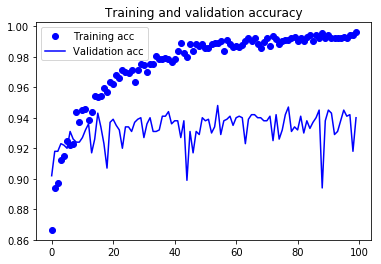

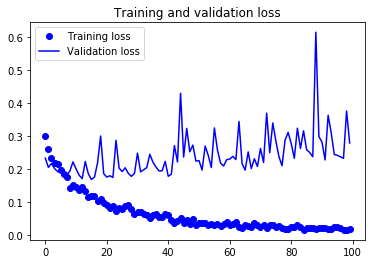

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Caso as curvas acima apresentem oscilações rápidas nos dados, podemos suaviza-las através do uso de médias móveis com suavização exponencial. Isto pode ser visto no código e gráficos a seguir:

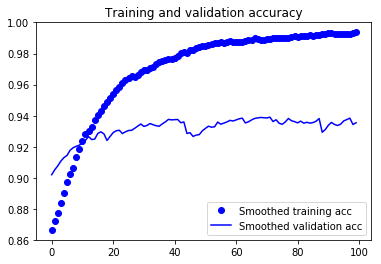

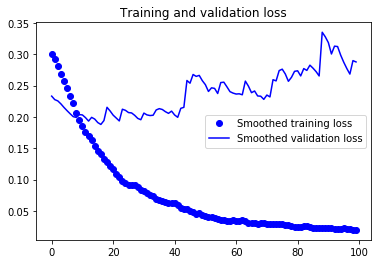

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apesar de termos atingido 94% de precisão na validação ainda temos um razoável grau de overfitting. 

Vamos agora testar o modelo no conjunto de teste.

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9449999904632569


Foi obtida uma precisão no teste de 94.5%. Apesar de não ser um resultado excelente, devemos lembrar que ele foi obtido com apenas 10% do conjunto original de imagens. Além disso ele representa uma grande melhora em relação aos 80% obtidos pelo primeiro modelo.

Isto foi possível pelo uso de técnicas modernas de regularização dos dados (L1, L2, L1_L2, dropout), redes pré-treinadas e ajuste fino das mesmas. 

## Conclusões


* Redes neurais convolutivas (convnets) são a melhor opção para modelos que envolvem reconhecimento de imagens. 

* Em pequenos conjuntos de dados o principal problema será o overfitting. A técnica mais utilizada para evitar o overfitting é o aumento de dados (`data augmentation`). 

* É possível reutilizar uma rede neural convolutiva pré-treinada em um novo conjunto de dados, em especial se o conjunto for pequeno.

* De forma complementar a extração de características, pode-se utilizar o ajuste fino, o qual adapta as camadas convolutivas finais de um modelo a um novo conjunto de dados.